### Using Python version 3.6 and Tensorflow version 1.7

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.set_random_seed(10)
import time

/Users/meenakshiparyani/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. (10pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    return enc

#Get the accuracy of the results
def get_accuracy(y, y_pred):
    y = tf.nn.softmax(y)
    y_pred = tf.nn.softmax(y_pred)
    labels_equal = tf.equal(y, y_pred)
    accuracy = tf.reduce_mean(tf.cast(labels_equal, 'float'))
    return accuracy

# Get the cost of iteration
def get_cost(y, y_pred):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))
    return cost

def plotCostHistory(cost_history):
     plt.plot(cost_history)
     plt.ylabel('Cost');
     plt.xlabel('Iterations');
     plt.title('Cost Progression with Iterations')
     plt.show()

def extract_parameters(hyper_params, key):
    hyper_param = hyper_params[key]
    pad = hyper_param["pad"]
    f = hyper_param["f"]
    stride = hyper_param["stride"]
    filters = hyper_param["channels"]
    #a_prev = tf.pad(a_prev, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")
    return pad, f, stride, filters

# Flatten the array
def flatten(A):
    return tf.layers.flatten(A)

# Forward propagation to calculate yHat
def forward_propagate_lenet5(x, hyper_params):
    print("************In forward************")
    # Layer 1 Convolution 
    pad_c1, f_c1, stride_c1, filters_out_c1 =  extract_parameters(hyper_params, "c1")
    a1_c = tf.layers.conv2d(inputs=x, filters=filters_out_c1, kernel_size=[f_c1,f_c1],strides=stride_c1, 
                            padding='same',activation=tf.nn.relu) # Relu Activation
    
    print(a1_c)
    
    # Layer 1 Pooling 
    pad_p1, f_p1, stride_p1, filters_out_p1 =  extract_parameters(hyper_params, "p1")
    print(f_p1)
    a1_p = tf.layers.max_pooling2d(inputs = a1_c,pool_size=[f_p1,f_p1], strides=stride_p1)
    print(a1_p)
 
    # Layer 2 Convolution 
    
    pad_c2, f_c2, stride_c2, filters_out_c2 =  extract_parameters(hyper_params, "c2")
    print(" pad {} f {} stid {} filters {}".format(pad_c2, f_c2, stride_c2, filters_out_c2))
    a2_c = tf.layers.conv2d(inputs = a1_p, filters=filters_out_c2, kernel_size=[f_c2,f_c2]
                    ,strides=stride_c2, padding='valid' , activation=tf.nn.relu) # Relu Activation
    print(a2_c)
    # Layer 2 Pooling 
    pad_p2, f_p2, stride_p2, filters_out_p2 =  extract_parameters(hyper_params, "p2")
    a2_p = tf.layers.max_pooling2d(inputs = a2_c, pool_size=[f_p2,f_p2], strides=stride_p2)
    
    print(a2_p)
    # Flatten the array
    a3 = flatten(a2_p)
    print(a3)
    

    # Fully Connected Layer 4
    fc1_size = hyper_params["4"]["size"]
    he_init = tf.contrib.layers.xavier_initializer()
    random_init = tf.random_uniform_initializer()
    a4 = tf.layers.dense(inputs = a3, units=fc1_size, activation=tf.nn.relu, kernel_initializer=he_init)
    print(a4)
    
    # Fully Connected Layer 5
    fc2_size = hyper_params["5"]["size"]
    xavier_init = tf.contrib.layers.xavier_initializer()
    random_init = tf.random_uniform_initializer()
    a5 = tf.layers.dense(inputs = a4, units=fc2_size, activation=tf.nn.sigmoid, kernel_initializer=xavier_init)
    print(a5)
    return a5

### 2. Load data

In [3]:
# Load Training Data
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
# indx = 2
# plt.imshow(X_train[indx])
# plt.show()
# print("Digit in the image is " + str(y_train[indx]))

# Normalize the training data
X_train_norm = (X_train/255.0) - 0.5
y_train_encoded = one_hot_encode(y_train)

# Load testing Data
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')
# indx = 2
# plt.imshow(X_test[indx])
# plt.show()
# print("Digit in the image is " + str(y_test[indx]))

# Normalize the test data
X_test_norm = (X_test/255.0) - 0.5
y_test_encoded = one_hot_encode(y_test)
print(X_test_norm.shape)
print(X_train_norm.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(180, 64, 64, 3)
(1020, 64, 64, 3)
(1020, 6)
(180, 6)


### 3. (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    hyper_params_c1["f"] = 2
    hyper_params_c1["channels"] = 8
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 2
    hyper_params_p1["channels"] = 8
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    hyper_params_c2["f"] = 2
    hyper_params_c2["channels"] = 16
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 2
    hyper_params_p2["channels"] = 16
    
    hyper_params_4 = {}
    hyper_params_4["size"] = 108
            
    hyper_params_5 = {}
    hyper_params_5["size"] = 6
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    hyper_params["4"] = hyper_params_4
    hyper_params["5"] = hyper_params_5
    
    return hyper_params

In [5]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# X_train_norm = tf.placeholder(tf.float32, [None, nH, nW, nC])
# print(X_train_norm.shape)
# y_pred = forward_propagate_lenet5(X_train_norm, hyper_params)

In [6]:
# hyper_params = initialize_hyper_params()
# (m, nH, nW, nC) = X_train_norm.shape
# x = tf.placeholder(tf.float32, [None, nH, nW, nC])
# y = tf.placeholder(tf.float32)
# y_pred = tf.placeholder(tf.float32)
# y_pred = forward_propagate_lenet5(x, hyper_params)
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# init = tf.global_variables_initializer()

# with tf.Session() as sess:
#     sess.run(init)
#     for epoch in range(1000):
#         _, c = sess.run([optimizer, cost], feed_dict = {x: X_train_norm, y: y_train_encoded})
#         if epoch % 10 == 0:
#             print ("Epoch:", (epoch), "cost =", "{:.5f}".format(c))
#             #print(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) 
#     actual_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
#     accuracy = tf.reduce_mean(tf.cast(actual_prediction, tf.float32))
#     accuracy_tr = accuracy.eval({x: X_train_norm, y: y_train_encoded})
#     accuracy_te = accuracy.eval({x: X_test_norm, y: y_test_encoded})
#     print ("Accuracy on Train Dataset using keep_prob = " + " :", accuracy_tr)
#     print("Accuracy on Test Dataset using keep_prob = "+ " :", accuracy_te)
# elapsed_time = time.time() - start_time
# print ("Time taken to run: ", float(elapsed_time/60))

### 4. (40pts) Build Convolution Neural Network model

In [7]:
def train_cnn_lenet5(epochs, X_train, y_train, X_test, y_test, learning_rate, keep_prob):
    tf.reset_default_graph()
    (m, nH, nW, nC) = X_train.shape
    x = tf.placeholder(tf.float32, [None, nH, nW, nC])
    y = tf.placeholder(tf.float32)
    hyper_params = initialize_hyper_params()
    y_pred = forward_propagate_lenet5(x, hyper_params)
    cost = get_cost(y, y_pred)
    
    # The AdamOptimizer is used to optimize the cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()
    correctness = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)) # Softmax Predictions
    accuracy = tf.reduce_mean(tf.cast(correctness, 'float'))
    cost_history = []
    max_test_acc = 0
    max_iter = 0
    train_acc = 0
    test_acc = 0
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs+1):
            temp, epoch_cost = sess.run([optimizer, cost], feed_dict={x:X_train, y:y_train})
            cost_history.append(epoch_cost)
            if(epoch % 1 == 0):
                train_acc = accuracy.eval({x:X_train, y:y_train})
                test_acc = accuracy.eval({x:X_test, y:y_test}) 
                if(test_acc > max_test_acc):
                    max_test_acc = test_acc
                    print('Max till now is ' , float(max_test_acc))
                    max_iter = epoch
                print('Accuracy Test: ' + str(test_acc) + ' on iteration ' + str(epoch))
                print('Cost is ' + str(epoch_cost) + ' for iteration: ' + str(epoch))
        plotCostHistory(cost_history)
        train_acc = train_acc * 100.0
        test_acc = test_acc * 100.0
        print('Train Accuracy: ', train_acc)
        print('Test Accuracy: ' ,test_acc)
        print('Max Test Accuracy: ' + str(max_test_acc* 100.0) + ' on iteration ' + str(max_iter))
        return train_acc, test_acc

### 5. (20pts) Optimization of Convolution Neural Network model

************In forward************
Tensor("conv2d/Relu:0", shape=(?, 32, 32, 8), dtype=float32)
2
Tensor("max_pooling2d/MaxPool:0", shape=(?, 31, 31, 8), dtype=float32)
 pad 0 f 2 stid 2 filters 16
Tensor("conv2d_1/Relu:0", shape=(?, 15, 15, 16), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 3136), dtype=float32)
Instructions for updating:
Use the retry module or similar alternatives.
Tensor("dense/Relu:0", shape=(?, 108), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 6), dtype=float32)
Max till now is  0.17222222685813904
Accuracy Test: 0.17222223 on iteration 0
Cost is 1.7920529 for iteration: 0
Accuracy Test: 0.17222223 on iteration 1
Cost is 1.7901822 for iteration: 1
Max till now is  0.17777778208255768
Accuracy Test: 0.17777778 on iteration 2
Cost is 1.7883168 for iteration: 2
Max till now is  0.1944444477558136
Accuracy Test: 0.19444445 on iteration 3
Cost is 1.7864032 for iteration: 3
Max ti

Accuracy Test: 0.6388889 on iteration 82
Cost is 1.5521809 for iteration: 82
Max till now is  0.644444465637207
Accuracy Test: 0.64444447 on iteration 83
Cost is 1.5488646 for iteration: 83
Max till now is  0.6555555462837219
Accuracy Test: 0.65555555 on iteration 84
Cost is 1.54556 for iteration: 84
Accuracy Test: 0.65555555 on iteration 85
Cost is 1.5422729 for iteration: 85
Accuracy Test: 0.65555555 on iteration 86
Cost is 1.5390047 for iteration: 86
Accuracy Test: 0.65555555 on iteration 87
Cost is 1.5357572 for iteration: 87
Max till now is  0.6611111164093018
Accuracy Test: 0.6611111 on iteration 88
Cost is 1.5325294 for iteration: 88
Accuracy Test: 0.6611111 on iteration 89
Cost is 1.5293196 for iteration: 89
Accuracy Test: 0.6611111 on iteration 90
Cost is 1.526127 for iteration: 90
Max till now is  0.6666666865348816
Accuracy Test: 0.6666667 on iteration 91
Cost is 1.5229543 for iteration: 91
Accuracy Test: 0.6666667 on iteration 92
Cost is 1.5198004 for iteration: 92
Max till

Accuracy Test: 0.76111114 on iteration 178
Cost is 1.3284785 for iteration: 178
Accuracy Test: 0.76111114 on iteration 179
Cost is 1.3269961 for iteration: 179
Accuracy Test: 0.76111114 on iteration 180
Cost is 1.3255256 for iteration: 180
Max till now is  0.7666666507720947
Accuracy Test: 0.76666665 on iteration 181
Cost is 1.3240675 for iteration: 181
Accuracy Test: 0.76666665 on iteration 182
Cost is 1.322622 for iteration: 182
Accuracy Test: 0.76666665 on iteration 183
Cost is 1.321189 for iteration: 183
Accuracy Test: 0.76666665 on iteration 184
Cost is 1.3197681 for iteration: 184
Accuracy Test: 0.76666665 on iteration 185
Cost is 1.3183594 for iteration: 185
Accuracy Test: 0.76111114 on iteration 186
Cost is 1.3169616 for iteration: 186
Accuracy Test: 0.76111114 on iteration 187
Cost is 1.3155757 for iteration: 187
Accuracy Test: 0.76111114 on iteration 188
Cost is 1.3142 for iteration: 188
Accuracy Test: 0.76111114 on iteration 189
Cost is 1.3128363 for iteration: 189
Accuracy 

Accuracy Test: 0.8 on iteration 279
Cost is 1.2229303 for iteration: 279
Accuracy Test: 0.8 on iteration 280
Cost is 1.2221961 for iteration: 280
Accuracy Test: 0.8 on iteration 281
Cost is 1.221466 for iteration: 281
Accuracy Test: 0.8 on iteration 282
Cost is 1.2207396 for iteration: 282
Accuracy Test: 0.8 on iteration 283
Cost is 1.2200173 for iteration: 283
Accuracy Test: 0.8 on iteration 284
Cost is 1.2192984 for iteration: 284
Accuracy Test: 0.8 on iteration 285
Cost is 1.218583 for iteration: 285
Accuracy Test: 0.8 on iteration 286
Cost is 1.2178713 for iteration: 286
Accuracy Test: 0.8 on iteration 287
Cost is 1.2171637 for iteration: 287
Accuracy Test: 0.8 on iteration 288
Cost is 1.216459 for iteration: 288
Accuracy Test: 0.8 on iteration 289
Cost is 1.2157587 for iteration: 289
Accuracy Test: 0.8 on iteration 290
Cost is 1.2150618 for iteration: 290
Accuracy Test: 0.8 on iteration 291
Cost is 1.2143676 for iteration: 291
Accuracy Test: 0.8 on iteration 292
Cost is 1.2136775 

Accuracy Test: 0.8111111 on iteration 384
Cost is 1.1630367 for iteration: 384
Accuracy Test: 0.8111111 on iteration 385
Cost is 1.1625909 for iteration: 385
Accuracy Test: 0.8111111 on iteration 386
Cost is 1.1621461 for iteration: 386
Accuracy Test: 0.8111111 on iteration 387
Cost is 1.161703 for iteration: 387
Accuracy Test: 0.8111111 on iteration 388
Cost is 1.1612611 for iteration: 388
Max till now is  0.8166666626930237
Accuracy Test: 0.81666666 on iteration 389
Cost is 1.1608219 for iteration: 389
Accuracy Test: 0.81666666 on iteration 390
Cost is 1.1603842 for iteration: 390
Accuracy Test: 0.81666666 on iteration 391
Cost is 1.1599488 for iteration: 391
Accuracy Test: 0.81666666 on iteration 392
Cost is 1.1595157 for iteration: 392
Accuracy Test: 0.81666666 on iteration 393
Cost is 1.1590846 for iteration: 393
Accuracy Test: 0.81666666 on iteration 394
Cost is 1.1586555 for iteration: 394
Max till now is  0.8277778029441833
Accuracy Test: 0.8277778 on iteration 395
Cost is 1.15

Accuracy Test: 0.85 on iteration 487
Cost is 1.1252743 for iteration: 487
Accuracy Test: 0.85 on iteration 488
Cost is 1.1249766 for iteration: 488
Accuracy Test: 0.85 on iteration 489
Cost is 1.1246799 for iteration: 489
Accuracy Test: 0.84444445 on iteration 490
Cost is 1.124384 for iteration: 490
Accuracy Test: 0.84444445 on iteration 491
Cost is 1.1240889 for iteration: 491
Accuracy Test: 0.84444445 on iteration 492
Cost is 1.1237953 for iteration: 492
Accuracy Test: 0.84444445 on iteration 493
Cost is 1.123502 for iteration: 493
Accuracy Test: 0.85 on iteration 494
Cost is 1.1232105 for iteration: 494
Accuracy Test: 0.85 on iteration 495
Cost is 1.1229198 for iteration: 495
Accuracy Test: 0.85 on iteration 496
Cost is 1.1226296 for iteration: 496
Accuracy Test: 0.85 on iteration 497
Cost is 1.1223407 for iteration: 497
Accuracy Test: 0.85 on iteration 498
Cost is 1.1220523 for iteration: 498
Accuracy Test: 0.85 on iteration 499
Cost is 1.1217651 for iteration: 499
Accuracy Test: 0

Accuracy Test: 0.8611111 on iteration 593
Cost is 1.0993811 for iteration: 593
Accuracy Test: 0.8611111 on iteration 594
Cost is 1.0991892 for iteration: 594
Accuracy Test: 0.8611111 on iteration 595
Cost is 1.0989984 for iteration: 595
Accuracy Test: 0.8611111 on iteration 596
Cost is 1.0988084 for iteration: 596
Accuracy Test: 0.8611111 on iteration 597
Cost is 1.0986198 for iteration: 597
Accuracy Test: 0.8611111 on iteration 598
Cost is 1.0984308 for iteration: 598
Accuracy Test: 0.8611111 on iteration 599
Cost is 1.0982425 for iteration: 599
Accuracy Test: 0.8611111 on iteration 600
Cost is 1.0980554 for iteration: 600
Accuracy Test: 0.8611111 on iteration 601
Cost is 1.0978683 for iteration: 601
Accuracy Test: 0.8611111 on iteration 602
Cost is 1.0976819 for iteration: 602
Accuracy Test: 0.8611111 on iteration 603
Cost is 1.0974967 for iteration: 603
Accuracy Test: 0.8611111 on iteration 604
Cost is 1.0973114 for iteration: 604
Accuracy Test: 0.8611111 on iteration 605
Cost is 1.

Accuracy Test: 0.87222224 on iteration 696
Cost is 1.0830426 for iteration: 696
Accuracy Test: 0.87222224 on iteration 697
Cost is 1.0829225 for iteration: 697
Accuracy Test: 0.87222224 on iteration 698
Cost is 1.0828046 for iteration: 698
Accuracy Test: 0.87222224 on iteration 699
Cost is 1.0826865 for iteration: 699
Accuracy Test: 0.87222224 on iteration 700
Cost is 1.0825682 for iteration: 700
Accuracy Test: 0.87222224 on iteration 701
Cost is 1.0824517 for iteration: 701
Accuracy Test: 0.87222224 on iteration 702
Cost is 1.0823362 for iteration: 702
Accuracy Test: 0.87222224 on iteration 703
Cost is 1.0822206 for iteration: 703
Accuracy Test: 0.87222224 on iteration 704
Cost is 1.0821059 for iteration: 704
Accuracy Test: 0.87222224 on iteration 705
Cost is 1.0819919 for iteration: 705
Accuracy Test: 0.87222224 on iteration 706
Cost is 1.0818784 for iteration: 706
Max till now is  0.8777777552604675
Accuracy Test: 0.87777776 on iteration 707
Cost is 1.0817655 for iteration: 707
Accu

Accuracy Test: 0.8833333 on iteration 799
Cost is 1.073457 for iteration: 799
Accuracy Test: 0.8833333 on iteration 800
Cost is 1.0733777 for iteration: 800
Accuracy Test: 0.8833333 on iteration 801
Cost is 1.0732992 for iteration: 801
Accuracy Test: 0.8833333 on iteration 802
Cost is 1.0732205 for iteration: 802
Accuracy Test: 0.8833333 on iteration 803
Cost is 1.0731413 for iteration: 803
Accuracy Test: 0.8833333 on iteration 804
Cost is 1.0730621 for iteration: 804
Accuracy Test: 0.8833333 on iteration 805
Cost is 1.0729835 for iteration: 805
Accuracy Test: 0.8833333 on iteration 806
Cost is 1.0729043 for iteration: 806
Accuracy Test: 0.8833333 on iteration 807
Cost is 1.0728252 for iteration: 807
Accuracy Test: 0.8833333 on iteration 808
Cost is 1.0727466 for iteration: 808
Accuracy Test: 0.8833333 on iteration 809
Cost is 1.072668 for iteration: 809
Accuracy Test: 0.8833333 on iteration 810
Cost is 1.0725896 for iteration: 810
Accuracy Test: 0.8833333 on iteration 811
Cost is 1.07

Accuracy Test: 0.8888889 on iteration 903
Cost is 1.0670329 for iteration: 903
Accuracy Test: 0.8888889 on iteration 904
Cost is 1.0669852 for iteration: 904
Accuracy Test: 0.8888889 on iteration 905
Cost is 1.0669366 for iteration: 905
Accuracy Test: 0.8888889 on iteration 906
Cost is 1.0668886 for iteration: 906
Accuracy Test: 0.8888889 on iteration 907
Cost is 1.0668404 for iteration: 907
Accuracy Test: 0.8888889 on iteration 908
Cost is 1.0667928 for iteration: 908
Accuracy Test: 0.8888889 on iteration 909
Cost is 1.0667442 for iteration: 909
Accuracy Test: 0.8888889 on iteration 910
Cost is 1.0666966 for iteration: 910
Accuracy Test: 0.8888889 on iteration 911
Cost is 1.0666491 for iteration: 911
Accuracy Test: 0.8888889 on iteration 912
Cost is 1.0666013 for iteration: 912
Accuracy Test: 0.8888889 on iteration 913
Cost is 1.0665534 for iteration: 913
Accuracy Test: 0.8888889 on iteration 914
Cost is 1.0665058 for iteration: 914
Accuracy Test: 0.8888889 on iteration 915
Cost is 1.

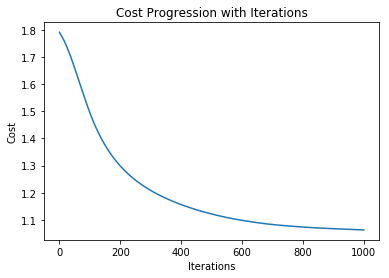

Train Accuracy:  97.9411780834198
Test Accuracy:  88.33333253860474
Max Test Accuracy: 88.88888955116272 on iteration 895


(97.9411780834198, 88.33333253860474)

In [8]:
train_cnn_lenet5(1000, X_train_norm, y_train_encoded, X_test_norm, y_test_encoded, 0.0001, 0.8)

### 5. (20pts) Predictions